In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rcParams
import time
import diffusionstuff10 as ds
from copy import copy as dup
from scipy.integrate import odeint
from scipy.integrate import solve_ivp

In [2]:
# Graphics parameters
%matplotlib notebook
ticklabelsize = 11
fontsize = 15
linewidth = 2

### The cell below specifies parameters for the 0-d and 1-d runs

<IPython.core.display.Javascript object>


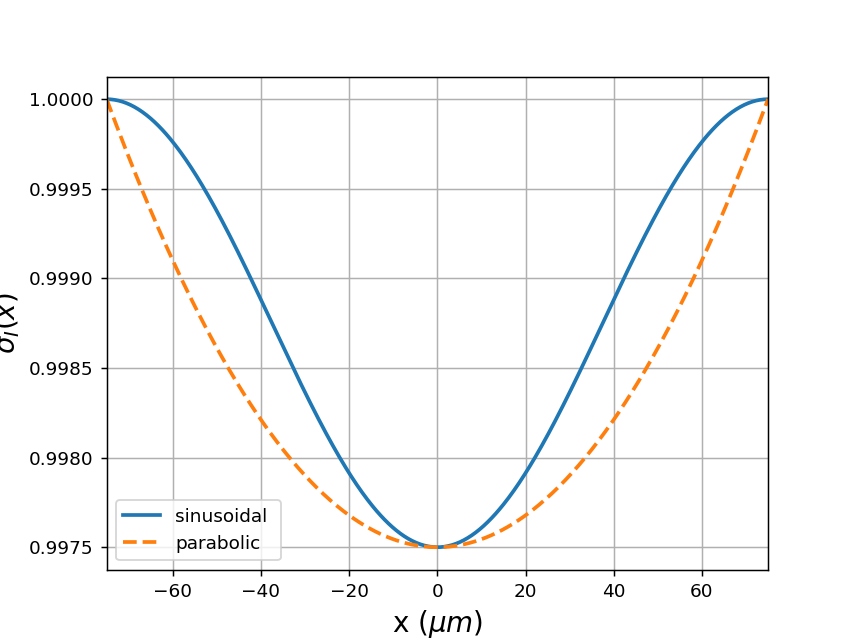

D = 0.00016 um^2/us 0.16 x 10^-9 m^2/sec
deltat_max (Diffusion time) = 562.4999999999999
deltat = 22.499999999999996
nu_kin_mlyperus = 0.8333333333333334 monolayers/us
nmid = 250
N* = 0.1432394487827058
N*x2pi = 0.9
Nbar, Nbar-N*, N*/Nbar = 1.0 0.8567605512172942 0.1432394487827058
deltax = 0.3
sigma_0 = 0.19
sigmaIcorner = 0.21
center reduction = 0.25 %
c_r = 0.0025 dimensionless
max growth rate = 52.5 um/sec
min growth rate = 4.999999999999998 um/sec
nu_kin = 250 um/sec
dx = 0.3
L = 75.0 micrometers


In [3]:
#Setting up the system
nx = 501 # Number of points in simulation box
xmax = 150
x = np.linspace(0, xmax, nx)
boxpoints = len(x)
deltax = x[1]-x[0]
Nbar = 1.0 # new Nbar from VMD, 260K
Nstar = .9/(2*np.pi)
nmid = int(nx/2)
xmid = max(x)/2
xmax = x[nx-1]
L = xmax/2

# Just conversions
nmpermonolayer = 0.3
umpersec_over_mlyperus = (nmpermonolayer/1e3*1e6)

# Diffusion coefficient
# D = 2e-4 # micrometers^2/microsecond
D = 1.6e-4 # micrometers^2/microsecond
# D = 2e-5 # micrometers^2/microsecond
# D = 8e-6 # micrometers^2/microsecond
# D = 2e-7 # micrometers^2/microsecond

# Time steps
dtmaxtimefactor = 50
dtmaxtimefactor = 25
dtmax = deltax**2/D
t_init = 0.0
deltat = dtmax/dtmaxtimefactor
tinterval = [t_init, t_init+deltat]

# Deposition rate
nu_kin = 34 # microns/second - about right for 240 K
nu_kin = 49 # microns/second - between 240 and 260 K
nu_kin = 250 # microns/second - about right for 260 K
nu_kin_mlyperus = nu_kin/umpersec_over_mlyperus # monolayers per microsecond

# Supersaturation
sigma0 = 0.19
sigmaIcorner = 0.20 # Must be bigger than sigma0 to get growth
sigmaIcorner = 0.21 # Must be bigger than sigma0 to get growth
center_reduction = 0.25 # In percent
c_r = center_reduction/100

# Diffusion coefficient scaled for this time step and space step
Doverdeltax2 = D/deltax**2

# Overlying supersaturation
sigmaI_sinusoid = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='sinusoid')
sigmaI_parabolic = ds.getsigmaI(x,xmax,center_reduction,sigmaIcorner,method='parabolic')
# sigmaIstyle = 'sinusoid'
sigmaIstyle = 'parabolic'
if sigmaIstyle=='sinusoid':
    sigmaI = sigmaI_sinusoid
elif sigmaIstyle=='parabolic':
    sigmaI = sigmaI_parabolic
else:
    print('bad choice')
plt.figure()
plt.plot(x-xmid,sigmaI_sinusoid/sigmaIcorner, \
         x-xmid, sigmaI_parabolic/sigmaIcorner, '--',lw=linewidth)
plt.xlim([-xmid,xmid])
plt.legend(['sinusoidal ', 'parabolic'])
plt.xlabel(r'x ($\mu m$)',fontsize=fontsize)
plt.ylabel(r'$\sigma_I(x) $',fontsize=fontsize)
plt.grid('on')

# 0D run parameters
uselayers = True
if uselayers:
    layermax_0D = 1000
else:
    countermax_0D = 100

# 1D run parameters
if uselayers:
    layermax_1D = 1000
else:
    countermax_1D = 15000

# Integrator
# odemethod ='Radau' # much too slow (implicit)
# odemethod ='BDF' # still slow (implicit), faster than Radau, results closest to DOP853 and LSODA
# odemethod ='DOP853' # slowest of explicit methods
odemethod ='LSODA' # results are a lot like DOP853, but faster
# odemethod ='RK45' # faster, but results look different from LSODA
# odemethod ='RK23' # fastest, produces V-shaped profiles

# Reporting
print("D =", D, 'um^2/us',D * 1e-12*1e6*1e9, 'x 10^-9 m^2/sec')
print('deltat_max (Diffusion time) =', dtmax)
print('deltat =', deltat)
print('nu_kin_mlyperus =', nu_kin_mlyperus, 'monolayers/us')
print('nmid =', nmid)
print('N* =', Nstar)
print('N*x2pi =', Nstar*2*np.pi)
print('Nbar, Nbar-N*, N*/Nbar =', Nbar, Nbar-Nstar, Nstar/Nbar)
print('deltax =', deltax)
print('sigma_0 =', sigma0)
print('sigmaIcorner =', sigmaIcorner)
print('center reduction =', center_reduction, '%')
print('c_r =', c_r, 'dimensionless')
print('max growth rate =', nu_kin_mlyperus*sigmaIcorner*umpersec_over_mlyperus, 'um/sec')
print('min growth rate =', nu_kin_mlyperus*(sigmaIcorner-sigma0)*umpersec_over_mlyperus, 'um/sec')
print('nu_kin =', nu_kin, 'um/sec')
print('dx =', deltax)
print('L =', L, 'micrometers')

### This is the 0-d run

In [4]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaIcorner, sigma0, nu_kin_mlyperus]

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_0D = 0
NQLL_init_0D = ds.getNQLL(Ntot_init_0D,Nstar,Nbar)

# Initialize the keeper arrays
tkeep_0D = []
ykeep_0D = []
tlast = t_init

# Call the ODE solver
ylast = np.array([NQLL_init_0D,Ntot_init_0D])
counter = 0
ttot = 0.0
while True:
    
    # Integrate up to next time step
    sol = solve_ivp(ds.f0d_solve_ivp, tinterval, ylast, dense_output=True, args=(params,),rtol=1e-12,method=odemethod)

    ylast = sol.y[:,-1]
    tlast += deltat
    
    # Stuff into keeper arrays
    ykeep_0D.append(ylast)
    tkeep_0D.append(tlast)
    
    # Update counters and see whether to break
    NQLLlast, Ntotlast = ylast
    counter += 1
    if uselayers:
        if Ntotlast > layermax_0D-1:
            break
    else:
        if counter > countermax_0D-1:
            break

In [5]:
# Convert results to a numpy array
ykeep_0D = np.array(ykeep_0D, np.float64)
NQLLkeep_0D = ykeep_0D[:,0]
Ntotkeep_0D = ykeep_0D[:,1]
tkeep_0Darr = np.array(tkeep_0D, np.float64)

0-D Modeled growth rate, um/s 14.19789340237611
0-D Modeled growth rate, ml/us 0.0473263113412537
0-D Modeled alpha 0.270436064807164


<IPython.core.display.Javascript object>


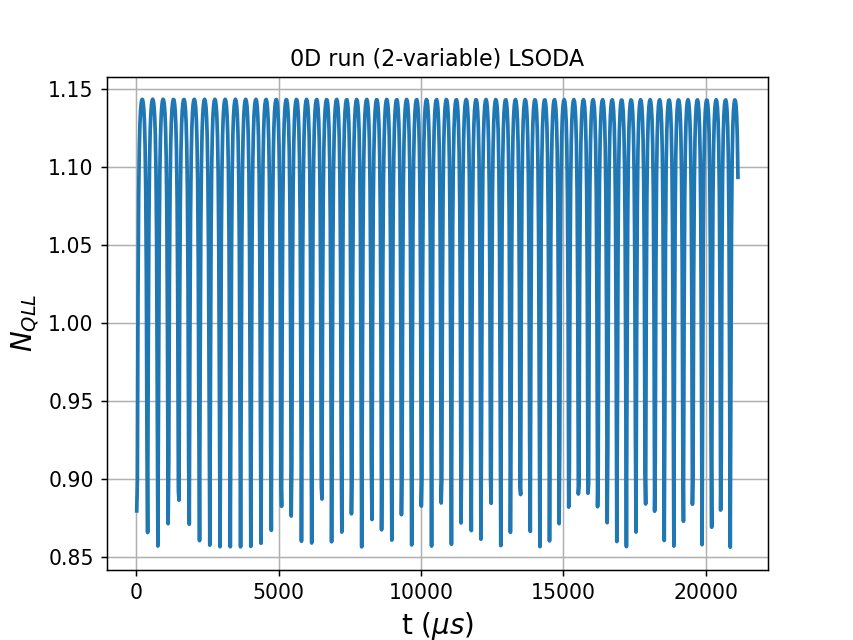

Text(0.5, 1.0, '0D run (2-variable) LSODA')

In [6]:
# Growth statistics
delta_Ntot_0D = Ntotkeep_0D[-1]-Ntot_init_0D
growthrate_0D_mlyperus = delta_Ntot_0D/tlast # monolayer/us
growthrate_0D = growthrate_0D_mlyperus*umpersec_over_mlyperus # um/sec
print( "0-D Modeled growth rate, um/s", growthrate_0D)
print( "0-D Modeled growth rate, ml/us", growthrate_0D_mlyperus)
alpha_0D = growthrate_0D/nu_kin/sigmaIcorner
print( "0-D Modeled alpha", alpha_0D)
title = '0D run (2-variable) '+odemethod

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_0D,ykeep_0D[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.grid('on')
plt.title(title)

### This is the 1-d run

In [7]:
# Bundle parameters for ODE solver
params = [Nbar, Nstar, sigmaI, sigma0, nu_kin_mlyperus, Doverdeltax2, nx] 

# Initialize as a pre-equilibrated layer of liquid over ice
Ntot_init_1D = np.ones(nx)
NQLL_init_1D = ds.getNQLL(Ntot_init_1D,Nstar,Nbar)

# Initialize the keeper arrays
tkeep_1D = []
ykeep_1D = []
tlast = t_init

# Call the ODE solver
ylast = np.array([NQLL_init_1D, Ntot_init_1D])
ylast = np.reshape(ylast,2*nx)
counter = 0
layer = 0
ttot = 0.0
while True:
    # Integrate up to next time step
    sol = solve_ivp(ds.f1d_solve_ivp, tinterval, ylast, args=(params,),rtol=1e-12,method=odemethod)
    ylast = sol.y[:,-1]
    tlast += deltat
        
    # Stuff into keeper arrays
    ykeep_1D.append(ylast)
    tkeep_1D.append(tlast)

    # Make some local copies
    ttot += deltat

    # Update counters and see whether to break
    NQLLlast, Ntotlast = np.reshape(ylast,(2,nx))
    minpoint = min(Ntotlast)
    maxpoint = max(Ntotlast)
    print(counter-1, int(Ntotlast[0]), maxpoint-minpoint)
    counter += 1
    if uselayers:
        if Ntotlast[0] > layermax_1D-1:
            break
    else:
        if counter > countermax_1D-1:
            break

-1 2 0.04861717422090228
0 3 0.10521316426712524
1 4 0.09734199773642338
2 5 0.07593820336290591
3 6 0.06143329263097996
4 7 0.05275472552924665
5 8 0.047843294878838094
6 9 0.045524093033794344
7 10 0.04521117692111609
8 11 0.046745336845706476
9 12 0.05030419410350184
10 13 0.05641724647704649
11 14 0.06620260178584125
12 15 0.08190454430656935
13 16 0.10814077607982497
14 17 0.15551667622154852
15 19 0.24922896416592266
16 20 0.42230247574445556
17 21 0.5879699889485366
18 22 0.663653840671909
19 23 0.6792283829437267
20 24 0.6490806377664988
21 25 0.564599483740583
22 26 0.424852705164561
23 27 0.2956071428017921
24 28 0.21790734563326453
25 29 0.1757046875708994
26 30 0.15350757260429404
27 31 0.14386787333021545
28 32 0.14394493414126686
29 33 0.153907310511876
30 34 0.17719881933331294
31 35 0.22336027748318088
32 37 0.3156317850107371
33 38 0.48679664661844413
34 39 0.664196138898518
35 40 0.7620359717735852
36 41 0.8101024983942509
37 42 0.8334605385553573
38 43 0.842200536567

314 333 1.1410964978450124
315 334 1.114337786066983
316 335 1.098908769407842
317 336 1.0904512362983496
318 337 1.0869947367285704
319 338 1.087841119921336
320 339 1.0932175210032824
321 340 1.1043828692776287
322 341 1.1242602798104713
323 342 1.1590671785532436
324 344 1.2216594506886622
325 345 1.3307260938444756
326 346 1.4653793149587386
327 347 1.5452203412273207
328 348 1.5444619997923041
329 349 1.4538394650811597
330 350 1.2933639083994422
331 351 1.1744777142183125
332 352 1.1129510892733379
333 353 1.0801720592006063
334 354 1.0612033443488826
335 355 1.0495072806779149
336 356 1.0420229851769136
337 357 1.037204365388277
338 358 1.0342343543634342
339 359 1.0326895414331716
340 360 1.032395527724134
341 361 1.033379469837314
342 362 1.0358943743210034
343 363 1.0405330589190385
344 364 1.0484976853571197
345 365 1.0620860835531403
346 367 1.0843134312947313
347 368 1.1056768186020918
348 369 1.0760733432959455
349 370 1.027075541879924
350 371 1.0041473797608091
351 372 

618 651 1.7660224786994831
619 652 1.8445848998107977
620 653 1.8867756640157722
621 654 1.9107583540132964
622 655 1.9250008692257552
623 656 1.9334464660855701
624 657 1.9380053854812331
625 658 1.9395678038403048
626 659 1.9384047603098224
627 660 1.9342776758114724
628 661 1.926336537910288
629 662 1.9127331319879204
630 663 1.8896497591414345
631 664 1.848979696991023
632 666 1.7740272103213783
633 667 1.6479803027594926
634 668 1.523965497562017
635 669 1.4807018749950203
636 670 1.5287193118766709
637 671 1.6585018397775002
638 672 1.7853298061207852
639 673 1.8585509700917555
640 674 1.8978936215740987
641 675 1.9202228536106531
642 676 1.9334920969345148
643 677 1.9414245949758424
644 678 1.9458391445876941
645 679 1.9476102941546287
646 680 1.9470600898378052
647 681 1.944087740082864
648 682 1.9381295490146613
649 683 1.927921207589975
650 684 1.9108870733630283
651 685 1.881661082616688
652 687 1.8286714556298875
653 688 1.7307743631553194
654 689 1.5924418264580709
655 690

922 971 0.9326210594437043
923 972 0.921655930607244
924 973 0.9027319708653749
925 974 0.869399547265516
926 975 0.8102691547716177
927 976 0.7252648282200198
928 978 0.6873064467524728
929 979 0.7698923196477381
930 980 0.8779438719203654
931 981 0.9357439550146864
932 982 0.9637647252684474
933 983 0.9786897938317907
934 984 0.9875283303656488
935 985 0.9933209162197727
936 986 0.9975343393291496
937 987 1.0009665422020362
938 988 1.0041242808399602
939 989 1.0074097214584299
940 990 1.0116557834973037
941 991 1.01714276964276
942 992 1.024888127092936
943 993 1.0367900304526074
944 994 1.0567832539958317
945 995 1.0938818819261087
946 997 1.1691215242431099
947 998 1.3037751358463083
948 999 1.4081581144210986


In [8]:
# Get the amount of ice for the last step
Nicelast = Ntotlast - NQLLlast

# Reshape results over time
tkeep_1Darr = np.array(tkeep_1D, np.float64)
ykeep_1Darr = np.array(ykeep_1D, np.float64)
ykeep_1Darr_reshaped = np.reshape(ykeep_1Darr,(counter,2,nx))
print(np.shape(ykeep_1Darr_reshaped))
Ntotkeep_1D = ykeep_1Darr_reshaped[:,1,:]
NQLLkeep_1D = ykeep_1Darr_reshaped[:,0,:]
Nicekeep_1D = Ntotkeep_1D - NQLLkeep_1D

(950, 2, 501)


1-D growth rate, ml/us 0.04665627344773244
1-D growth rate, um/s 13.996882034319732
1-D alpha 0.2666072768441854
slowdown -1.41 %
Libbrecht's predicted growth rate 10.043193213321738 um/s
Libbrecht's predicted alpha 0.1912989183489855


<IPython.core.display.Javascript object>


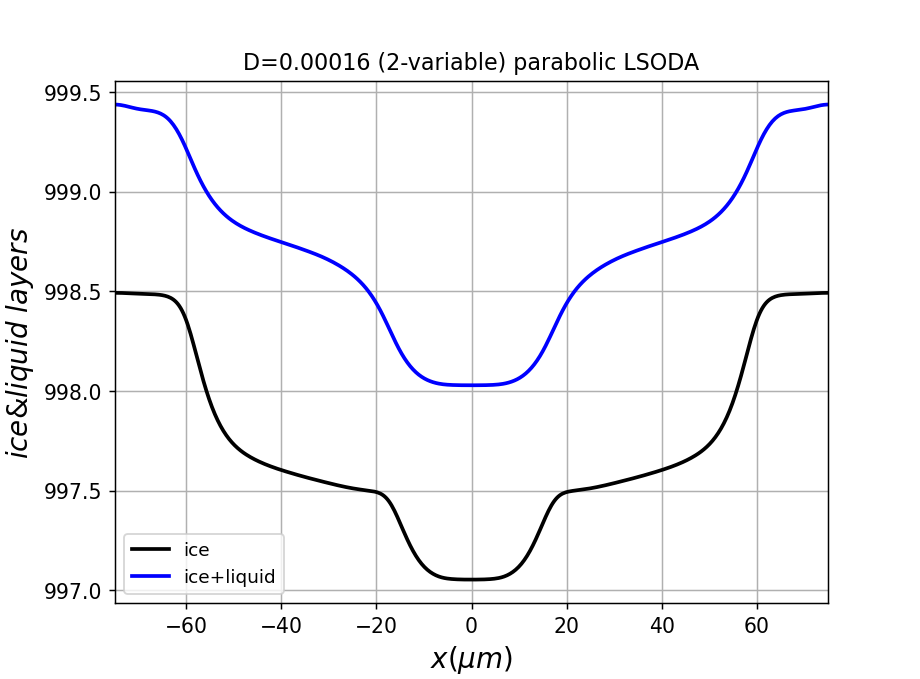

<IPython.core.display.Javascript object>


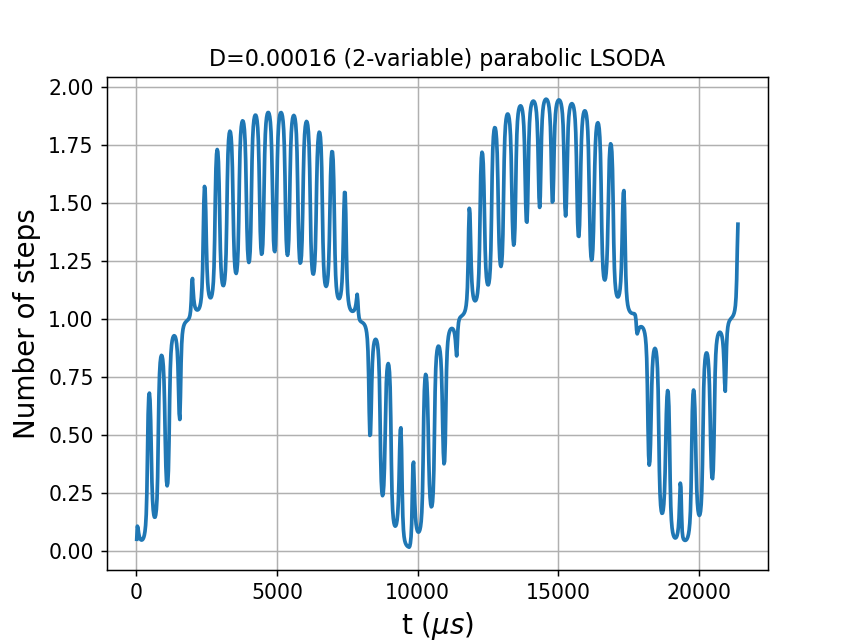

<IPython.core.display.Javascript object>


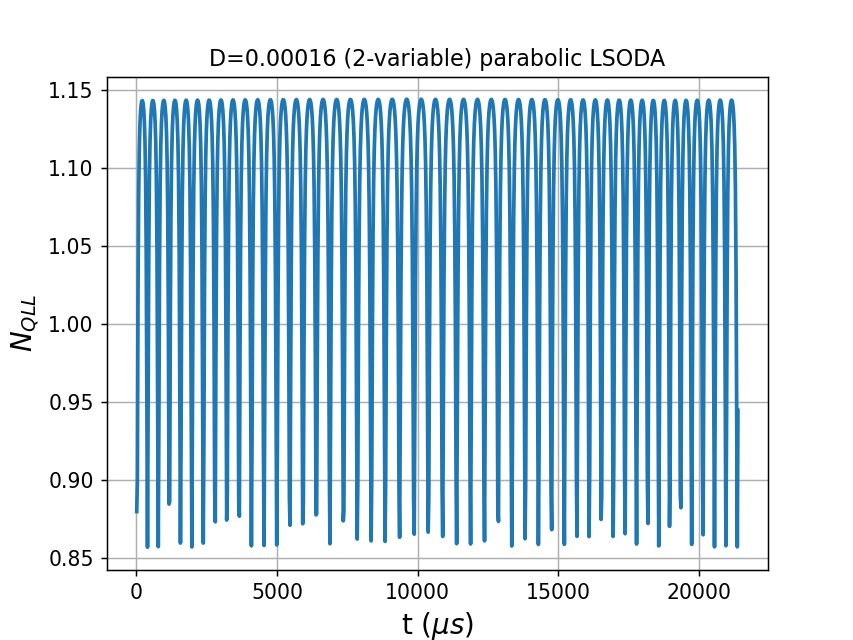

In [9]:
# Growth statistics
delta_Ntot_1D = Ntotkeep_1D[-1,0]-Ntotkeep_1D[0,0]
growthrate_1D_mlyperus = delta_Ntot_1D/tlast; print( "1-D growth rate, ml/us", growthrate_1D_mlyperus)
growthrate_1D = growthrate_1D_mlyperus*umpersec_over_mlyperus; print( "1-D growth rate, um/s", growthrate_1D)
alpha_1D = growthrate_1D/nu_kin/sigmaIcorner; print( "1-D alpha", alpha_1D)
slowdown = (alpha_1D-alpha_0D)/alpha_0D*100; print("slowdown", int(slowdown*100)/100,'%')
Nicekeep_1D = Ntotkeep_1D-NQLLkeep_1D
title = 'D='+str(D)+' (2-variable) '+sigmaIstyle+' '+odemethod

# Comparisons with Libbrecht
sigma0_L = 0.08
A_L = .28
alpha_L = A_L*np.exp(-sigma0_L/sigmaIcorner)
print("Libbrecht's predicted growth rate", nu_kin*alpha_L*sigmaIcorner, "um/s")
print("Libbrecht's predicted alpha", alpha_L)

# Plot ice and liquid
plt.figure()
plt.plot(x-xmid, Nicekeep_1D[-1,:], 'k', label='ice', lw=linewidth)
plt.plot(x-xmid, Ntotkeep_1D[-1,:], 'b', label='ice+liquid', lw=linewidth)
plt.xlabel(r'$x (\mu m$)',fontsize=fontsize)
plt.ylabel(r'$ice & liquid \ layers$',fontsize=fontsize)
plt.xlim([-xmid, xmid])
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.legend()
plt.title(title)
plt.grid('on')

# Plot number of steps over time
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
f = np.max(Ntotkeep_1D,axis=1) - np.min(Ntotkeep_1D,axis=1)
plt.plot(tkeep_1D,f,lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel('Number of steps',fontsize=fontsize)
plt.title(title)
plt.grid('on')

# Plot results
plt.figure()
rcParams['xtick.labelsize'] = ticklabelsize 
rcParams['ytick.labelsize'] = ticklabelsize
plt.plot(tkeep_1D,NQLLkeep_1D[:,0],lw=linewidth)
plt.xlabel(r't ($\mu s$)',fontsize=fontsize)
plt.ylabel(r'$N_{QLL} $',fontsize=fontsize)
plt.title(title)
plt.grid('on')

### The cell below is just backup for parameters, and allows some exploration (but not part of the simulation)

In [10]:
# # The time required for an initial gaussian to diffuse
# layer_growth_rate = growthrate_0D/umpersec_over_mlyperus; print('Layer growth rate =', layer_growth_rate)
# t1 = 1/layer_growth_rate; print('Time_to_add_a_layer =', t1)
# t2 = 2.5**2/D; print('Time to diffuse across a terrace =', t2)
# t3 = 0.2**2/D; print('Time to diffuse into a step =', t3)
# t4 = 0.001; print('Time for ice-QLL equilibration =', t4)

# # How a change in the crystal size could be used to calculate a new diffusion coefficient with the same D/dx^2
# D_old = 2e-6
# D_new = D_old/50**2*100**2; print(D_new)

# # Computing the kinetic deposition velocity ... roughly, 260 
# import numpy as np
# M = 18 # g/mol
# T = 260 # K
# NA = 6.02e23
# m = M/NA; print(m,'mass of a molecule of water, grams/mol')
# m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
# R = 8.314 # J/K-mol
# k = R/NA; print(k,"Boltzmann's constant, J/K")

# Pvap = 200 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
# V_gas = R*T/Pvap # Must be in m^3
# V_gas *= (10/1)**3; print(V_gas, 'Liters') 
# V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
# c_sat = 1/V_gas # mol/cm^3
# c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

# c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
# V_solid = 1/c_solid # cm^3/g

# V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
# c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

# sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
# nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
# nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# # Computing the kinetic deposition velocity ... roughly, 240 K has nukin of 40 um/s (we used 49 um/s in the paper)
# M = 18 # g/mol
# T = 240 # K
# NA = 6.02e23
# m = M/NA; print(m,'mass of a molecule of water, grams/mol')
# m /= 1e3; print(m,'mass of a molecule of water, kg/mol')
# R = 8.314 # J/K-mol
# k = R/NA; print(k,"Boltzmann's constant, J/K")

# Pvap = 26 # Pascals (see https://byjus.com/clausius-clapeyron-equation-calculator/)
# V_gas = R*T/Pvap # Must be in m^3
# V_gas *= (10/1)**3; print(V_gas, 'Liters') 
# V_gas *= (10/1)**3; print(V_gas, 'cm^3') # see https://www.omnicalculator.com/physics/ideal-gas-law
# c_sat = 1/V_gas # mol/cm^3
# c_sat*=M; print(c_sat,'density of vapor, g/cm^3')

# c_solid = 0.92; print(c_solid, 'density of ice, g/cm^3')
# V_solid = 1/c_solid # cm^3/g

# V_ratio = V_gas/V_solid; print(V_ratio,'ratio of volumes')
# c_ratio = c_sat/c_solid; print(c_ratio,'ratio of densities')

# sqrtfactor = np.sqrt(k*T/(2*np.pi*m))
# nukin = c_sat/c_solid*sqrtfactor; print(nukin,'kinetic velocity, m/s')
# nukin *= 1e6; print(nukin, 'kinetic velocity, um/s')

# # Gladich et al recommendation
# D_Gladich = 0.16e-9 # m^2/s
# D_Gladich *= (1e6/1)**2*(1/1e6); print('Gladich says, for 260 K, D = ', D_Gladich)